# Part02: Survey of machine learning models for CA housing data

In this chapter I survey a range of machine learning models, including ridge, support vector, random forest, and gradient boosting regression models.  I am interested in finding a "best" model for predicting median_house_value.

The g03 linear model from Part01 had a comparative rmse score of \\$75,471; when predicting only for districts with a median_house_value < 500K, the error score drops to \\$55,832.  Most of the ML algorithms surveyed below should be able to beat these scores.



In [1]:
import os

os.getcwd()


'/home/greg/Documents/stat/github_repos/CA_housing'

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline  
                    
import matplotlib as mpl
import matplotlib.pyplot as plt


In [3]:
# Ignore useless warnings (see SciPy issue #5998)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### Load training and test sets created in Part01

In [4]:
train = pd.read_csv('/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_27JUN2021.csv',
                    index_col=0)

test = pd.read_csv('/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_27JUN2021.csv',
                   index_col=0)

print(train.shape)
print(test.shape)


(16482, 16)
(4121, 16)


In [17]:
train.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_hh,bdrms_per_room,pop_per_hh,HHdens_ln,long_transf,income_cat
334,-122.17,37.74,43.0,818,193,494,179,2.4776,101600.0,NEAR BAY,4.569832,0.235941,2.759777,8.218130,3.460750,2
1662,-121.94,37.93,16.0,3421,427,1341,428,7.5695,320400.0,INLAND,7.992991,0.124817,3.133178,7.176395,3.897225,5
8781,-118.32,33.79,35.0,2924,658,1675,602,3.8287,279900.0,OCEAN,4.857143,0.225034,2.782392,8.339524,3.018262,3
9392,-122.54,37.90,48.0,2491,460,937,455,4.4375,370000.0,NEAR BAY,5.474725,0.184665,2.059341,7.156191,3.264623,3
10706,-117.72,33.61,26.0,2033,463,618,450,2.5685,80400.0,OCEAN,4.517778,0.227742,1.373333,8.697871,3.422655,2


In [5]:
# Remove income_cat and longitude.  Longitude has been mapped
# to long_transf.

y_train = train['median_house_value'].copy()
X_train = train[['housing_median_age','total_rooms','total_bedrooms',
                 'population','households','median_income',
                 'ocean_proximity','rooms_per_hh','bdrms_per_room',
                 'pop_per_hh','HHdens_ln','long_transf','latitude']].copy()
print(y_train.shape)
print(X_train.shape)


(16482,)
(16482, 13)


In [19]:
y_train.__class__


pandas.core.series.Series

In [20]:
# Recall that we removed the 'ISLAND' records since there 
# were only 5 in the entire 20.64K dataset. 
pd.value_counts(X_train['ocean_proximity'])


OCEAN         7338
INLAND        5187
NEAR OCEAN    2137
NEAR BAY      1820
Name: ocean_proximity, dtype: int64

In [6]:
y_test = test['median_house_value'].copy()
y_test.name = 'median_house_value'
X_test = test[['housing_median_age','total_rooms','total_bedrooms',
                 'population','households','median_income',
                 'ocean_proximity','rooms_per_hh','bdrms_per_room',
                 'pop_per_hh','HHdens_ln','long_transf','latitude']].copy()
print(y_test.shape)
print(X_test.shape)


(4121,)
(4121, 13)


In [23]:
# The training set and test data have median house values > 500K.
# In other words, we are working with about 4.8% imputed data
# for this variable.

round(y_test.describe())


count      4121.0
mean     210578.0
std      130124.0
min       22500.0
25%      118200.0
50%      178800.0
75%      262300.0
max      777151.0
Name: median_house_value, dtype: float64

### Plot of age vs median_house_value

In [58]:
df_GE52 = train[train.housing_median_age >= 52]
print(df_GE52.shape)
print("Median:  " + str(df_GE52.median_house_value.describe()['50%']))
print("Mean:    " + str(round(df_GE52.median_house_value.describe()['mean'])))


(1011, 16)
Median:  261500.0
Mean:    292187


In [59]:
df_LT52 = train[train.housing_median_age < 52]
print("Median:  " + str(df_LT52.median_house_value.describe()['50%']))
print("Mean:    " + str(round(df_LT52.median_house_value.describe()['mean'])))


Median:  176500.0
Mean:    207439


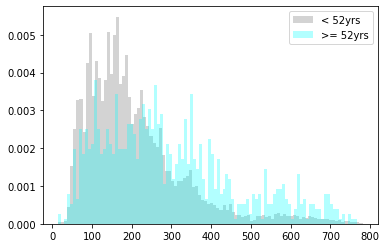

In [54]:
# There is some differentiation of median house value by age.
# The medians differ by 85K.  The means differ by 85K.

plt.hist(round(df_LT52.median_house_value / 1000), bins=100, 
         density=True, color='lightgrey', label='< 52yrs')
plt.hist(round(df_GE52.median_house_value / 1000), bins=100, 
         density=True, color='cyan', label='>= 52yrs', alpha=0.3)
plt.legend();


### Load some of the functions we will need

In [7]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error



In [8]:
# Distinguish between the numerical and categorical features.
# We will use this distinction in some of the pipelines below.

num_attribs = list(X_train.drop(["ocean_proximity"], axis=1).columns)
cat_attribs = ["ocean_proximity"]
print(num_attribs)

# There are 13 attributes altogether, excluding the response variable.

# Population and households have a very high positive correlation.
# Both are highly correlated with total_rooms and total_bedrooms.


['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hh', 'bdrms_per_room', 'pop_per_hh', 'HHdens_ln', 'long_transf', 'latitude']


In [8]:
# This function is useful for displaying scores from cross_val_score.

def display_scores(scores):
    print("Mean: ", round(scores.mean(), 0))
    print("StdDev: ", round(scores.std(), 0))
    

In [9]:
# Function to obtain comparative rmse scores.  For most scores
# I average scores from 500 samples of the testset data, each
# sample having 1000 records.

def get_rmse(seedv, dat):
    
    # dat needs to also have median_house_value as a column.
    n_rcds = 1000
    seedv_len = len(seedv)
    vout = np.zeros(seedv_len)
    
    for i, seed in enumerate(seedv):
        
        df = dat.sample(n=n_rcds, replace=False, random_state=seed, axis=0)
        y_df = df["median_house_value"].copy()
        df.drop(["median_house_value"], inplace=True, axis=1)
        test_score = grid.score(df, y_df)
        vout[i] = np.power(-test_score, 0.5)
    
    # print(np.round(vout[:10]))
    # print(vout[vout < 50000])
    return round(np.mean(vout[i]))
    

# Section 1: ML linear models: OLS, ridge, and lasso

For most of the linear models that follow, I use only the 6 predictors used in the g03 model of Part01.  The work done in Part01 shows that we are likely to get better linear models using only median_income, long_transf, latitude, pop_per_hh, housing_median_age, and HHdens_ln.


## OLS model

In [10]:
X_train_6preds = X_train[['median_income','long_transf','latitude',
                          'pop_per_hh','HHdens_ln','housing_median_age']].copy()

X_test_6preds = X_test[['median_income','long_transf','latitude',
                          'pop_per_hh','HHdens_ln','housing_median_age']].copy()


In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [46]:
# A simple regression with the 6 predictors.

lin_reg_cv_scores = cross_val_score(LinearRegression(), X_train_6preds, y_train, 
                                    scoring="neg_mean_squared_error",
                                    cv=10, n_jobs=10)

lin_reg_scores = np.sqrt(-lin_reg_cv_scores)
display_scores(lin_reg_scores)


Mean:  79297.0
StdDev:  2650.0


In [47]:
# Here I apply the scaler AFTER the polynomial transformations.  
# The order matters for the scaler that is chosen in the grid
# search.  (Typically I apply the scaler first.)

pipe = Pipeline([('poly', PolynomialFeatures()), 
                 ('scaler', MinMaxScaler()),
                 ('model', LinearRegression())])


In [48]:
# A parameter grid for LinearRegression().

param_grid = {'poly__degree': [1,2,3], 
              'scaler': [StandardScaler(), MinMaxScaler(),
                         None, RobustScaler()]}


In [49]:
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)

grid.best_params_
# {'poly__degree': 3, 'scaler': None}


{'poly__degree': 3, 'scaler': None}

In [50]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 68,141
#  Test-set score: 66,259    

# These scores are much better than what we saw for the g03 model in Part01.
# This model is much more complex though, with 84 terms (g03 has 15 terms).


Best cross-validation score: 68141
Test-set score: 66259


In [ ]:
### COMMENTS:

# In this instance the grid search returns the same values 
# if we apply the scaler prior to the polynomial transformation.


### Get comparative score for the OLS model

For consistency, I apply a procedure similar to what I used at the end of Part01.  I take 500 1000-record samples from the testset data and compute an rmse score for each.  I then take the average of these 500 scores.

In [78]:
# The following is a score for all test districts.

testdat = X_test_6preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

OLS_rmse = get_rmse(smp, testdat)

print("Comparative rmse score for ML OLS model:  " + '$' +
      f'{OLS_rmse:,.0f}')

# $61,151

# For the g03 model of Part01, this score was 75.5K.


Comparative rmse score for ML OLS model:  $61,151


In [79]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

OLS_rmse = get_rmse(smp, testdat2)

print("Comparative rmse score for ML OLS model when median house value < 500K:  " + '$' +
      f'{OLS_rmse:,.0f}')

# $57,448

# For the g03 model in Part01, this score was 55.8K.


Comparative rmse score for ML OLS model when median house value < 500K:  $57,448


In [82]:
# The difference between the 2 testsets is about 200 records.

print(testdat2.shape)
print(testdat.shape)


(3924, 7)
(4121, 7)


### OLS Comments

The score on 500 samples from the test set data is much lower than what we saw with the g03 model of Part01.  g03's score was 75.5K.  The delta is about 14.4K.

But if we limit the test districts to those with a median house value < 500K, the g03 model out-performs the ML OLS model by 1.6K.


**OLS best score on test set:**  **61,151**


## Ridge model

In [83]:
# Here the scaling is done first.

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('poly', PolynomialFeatures()), 
                 ('model', Ridge())])


In [11]:
# Keep track of the computing time.

from datetime import datetime


In [85]:
# Parameter grid for Ridge():

# Increasing the alpha parameter "regularizes" the coefficients 
# toward zero (L2 norm), which can improve the generalizability
# of the model.
param_grid = {'poly__degree': [1,2,3,4], 
              'model__alpha': list((0.01, 0.1, 1.0, 10) + tuple(range(50, 250, 50)))}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.05 minutes

grid.best_params_
# {'model__alpha': 0.01, 'poly__degree': 4}


Time difference of 0.05 minutes


{'model__alpha': 0.01, 'poly__degree': 4}

In [86]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 66.5K
#  Test-set score: 64.5K


Best cross-validation score: 66522
Test-set score: 64453


In [33]:
# Have the scaler follow the polynomial transformations.

pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('scaler', MinMaxScaler()),
                 ('model', Ridge())])


In [88]:

param_grid = {'poly__degree': [1,2,3,4], 'scaler': [StandardScaler(), MinMaxScaler(), 
                                                    RobustScaler()],
              'model__alpha': list((0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1.0, 10))}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.1 minutes

grid.best_params_
# {'model__alpha': 0.01, 'poly__degree': 4, 'scaler': MinMaxScaler()}


Time difference of 0.1 minutes


{'model__alpha': 0.01, 'poly__degree': 4, 'scaler': MinMaxScaler()}

In [89]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 66.5K
#  Test-set score: 64.4K


Best cross-validation score: 66522
Test-set score: 64453


In [73]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('poly', PolynomialFeatures()), 
                 ('model', Ridge())])


In [90]:
# This repeats what we first did above for Ridge, but the
# search grid now extends over different scalers.

param_grid = {'poly__degree': [1,2,3,4], 'scaler': [StandardScaler(), MinMaxScaler(), 
                                                    RobustScaler()],
              'model__alpha': [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 1.0, 10]}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.1 minutes

grid.best_params_
# {'model__alpha': 0.01, 'poly__degree': 4, 'scaler': MinMaxScaler()}


Time difference of 0.1 minutes


{'model__alpha': 0.01, 'poly__degree': 4, 'scaler': MinMaxScaler()}

In [91]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 66.5K
#  Test-set score: 64.5K


Best cross-validation score: 66522
Test-set score: 64453


### Get comparative score for the Ridge model

In [93]:
# The following is a score for all test districts.

testdat = X_test_6preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the Ridge model:  " + '$' +
      f'{rmse_score:,.0f}')

# $59,851

# For the g03 model of Part01, this score was 75.5K.

# The ML OLS model's score was: $61,151


Comparative rmse score for the Ridge model:  $59,851


In [94]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

rmse_score = get_rmse(smp, testdat2)

print("Comparative rmse score for the Ridge model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $55,282

# For the g03 model in Part01, this score was 55.8K.

# For the ML OLS model, the score was 57.5K.


Comparative rmse score for the Ridge model when median house value < 500K:  $55,282


### Comments on Ridge model using only the 6 predictors of the g03 model

Thus far, our best predictive model is the ridge regression.


**Ridge model *tentative* best score on test set:** **59.9K**



## Add more predictors to the Ridge model

We can improve the ridge model somewhat by adding predictors total_rooms and rooms_per_hh.

From what I am seeing, the categorical variable, ocean_proximity, does not help us get a better predictive model.  (I hedge because there are a number of combinations with ocean_proximity that I do not test in what follows.)


In [104]:
# In Part01 we saw that households and population are too highly
# correlated to include together.  We also see below that 
# total_bedrooms is highly correlated with population and total_rooms.

corr_matrix = train[['total_rooms','total_bedrooms',
                     'population', 'rooms_per_hh',
                     'bdrms_per_room','pop_per_hh']].corr()
corr_matrix


,total_rooms,total_bedrooms,population,rooms_per_hh,bdrms_per_room,pop_per_hh
total_rooms,1.000000,0.926511,0.858527,0.189991,-0.197630,-0.110973
total_bedrooms,0.926511,1.000000,0.874802,0.002857,0.084066,-0.146140
population,0.858527,0.874802,1.000000,-0.074324,0.020928,0.177688
rooms_per_hh,0.189991,0.002857,-0.074324,1.000000,-0.564184,-0.056187
bdrms_per_room,-0.197630,0.084066,0.020928,-0.564184,1.000000,0.007697
pop_per_hh,-0.110973,-0.146140,0.177688,-0.056187,0.007697,1.000000


In [105]:
# Do not include total_bedrooms or households.

X_train_raw = train[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','bdrms_per_room','pop_per_hh',
                         'ocean_proximity','long_transf','latitude']].copy()
print(X_train_raw.shape)


(16482, 11)


In [107]:
X_test_raw = test[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','bdrms_per_room','pop_per_hh',
                         'ocean_proximity','long_transf','latitude']].copy()
print(X_test_raw.shape)


(4121, 11)


In [108]:
num_attribs_raw = list(X_train_raw.drop(["ocean_proximity"], axis=1).columns)

cat_attribs_raw = ['ocean_proximity']


In [109]:
preproc = ColumnTransformer([
    ("num", MinMaxScaler(), num_attribs_raw),
    ("cat", OneHotEncoder(sparse=False), cat_attribs_raw),
])


In [110]:
pipe = Pipeline([("prep_dat", preproc),
                 ('poly', PolynomialFeatures()), 
                 ('model', Ridge())])


In [113]:
# On my machine Ridge struggles when we test poly__degree=5.    

param_grid = {'poly__degree': [3,4],
              'model__alpha': [0.01, 0.03, 0.05]}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid.fit(X_train_raw, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.28 minutes.

grid.best_params_
# {'model__alpha': 0.03, 'poly__degree': 4}


Time difference of 0.28 minutes


{'model__alpha': 0.03, 'poly__degree': 4}

In [114]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_raw, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 63.7K
#  Test-set score: 63.0K


Best cross-validation score: 63737
Test-set score: 63037


### Get comparative score for the Ridge model that uses more predictors

In [115]:
# The following is a score for all test districts.

testdat = test[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','bdrms_per_room','pop_per_hh',
                         'ocean_proximity','long_transf','latitude',
                'median_house_value']].copy()

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the Ridge model with more predictors:  " + '$' +
      f'{rmse_score:,.0f}')

# $63,197

# For the simpler ridge model this score was 59.85K.


Comparative rmse score for the Ridge model with more predictors:  $63,197


In [116]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

rmse_score = get_rmse(smp, testdat2)

print("Comparative rmse score for 2nd Ridge model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $52,511

# For the simpler ridge model this score was 55.3K.


Comparative rmse score for 2nd Ridge model when median house value < 500K:  $52,511


### Remove ocean_proximity and bdrms_per_room

In [12]:
X_train_raw = train[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','pop_per_hh',
                         'long_transf','latitude']].copy()
print(X_train_raw.shape)


(16482, 9)


In [13]:
X_test_raw = test[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','pop_per_hh',
                         'long_transf','latitude']].copy()
print(X_test_raw.shape)


(4121, 9)


In [120]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('poly', PolynomialFeatures()), 
                 ('model', Ridge())])


In [121]:
param_grid = {'poly__degree': [3,4],
              'model__alpha': [0.01, 0.03, 0.05]}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid.fit(X_train_raw, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.03 minutes.

grid.best_params_
# {'model__alpha': 0.01, 'poly__degree': 4}


Time difference of 0.03 minutes


{'model__alpha': 0.01, 'poly__degree': 4}

In [122]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_raw, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 66.3K
#  Test-set score: 63.3K


Best cross-validation score: 66264
Test-set score: 63263


### Get comparative score for this new ridge model

In [123]:
# The following is a score for all test districts.

testdat = test[['housing_median_age','total_rooms',
                         'population','median_income','HHdens_ln',
                         'rooms_per_hh','pop_per_hh',
                         'long_transf','latitude',
                'median_house_value']].copy()

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the 3rd Ridge model:  " + '$' +
      f'{rmse_score:,.0f}')

# $59,492

# For the simpler ridge model this score was 59.85K.


Comparative rmse score for the 3rd Ridge model:  $59,492


In [124]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

rmse_score = get_rmse(smp, testdat2)

print("Comparative rmse score for 3rd Ridge model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $53,843

# For the simpler ridge model this score was 55.3K.


Comparative rmse score for 3rd Ridge model when median house value < 500K:  $53,843


In [17]:
# Find out how many terms are in our ridge model.

# We can compute this directly.  We have 9 predictors and
# the polynomial degree is 4.  (9 + 4)! / 9!4! = 715 terms.

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('poly', PolynomialFeatures(degree= 4)), 
                 ])
X_prepared = pipe.fit_transform(X_train_raw)

ridge_reg = Ridge(alpha=0.01).fit(X_prepared, y_train)
len(ridge_reg.coef_)
# 715

# The g03 model from Part01 contains only 15 terms.


715

## Final comments for the Ridge model

**Ridge model best score on test set:** **59.5K**

The corresponding OLS regression score is 61.2K.  The g03 model had a score of 75.5K.  The Ridge model is more complex than either of these 2 models.



## Lasso model with 6 predictors

In [143]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('poly', PolynomialFeatures()), 
                 ('model', Lasso(max_iter=10000, tol=0.001))])


In [145]:
# Parameter grid for Lasso():

param_grid = {'poly__degree': [3,4,5], 
              'model__alpha': [15, 20, 25]}

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 1.77 minutes

grid.best_params_
# {'model__alpha': 15, 'poly__degree': 5}


Time difference of 1.77 minutes


{'model__alpha': 15, 'poly__degree': 5}

In [146]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 69.3K
#  Test-set score: 67.3K    


Best cross-validation score: 69305
Test-set score: 67282


### Get comparative score for the lasso model

In [148]:
# The following is a score for all test districts.

testdat = X_train_6preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the lasso model:  " + '$' +
      f'{rmse_score:,.0f}')

# $64,014

# The best ridge model has a score of 59.5K.


Comparative rmse score for the lasso model:  $64,014


In [150]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

rmse_score = get_rmse(smp, testdat2)

print("Comparative rmse score for the lasso when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $56,892

# The best ridge model has a score of 53.8K.


Comparative rmse score for the lasso when median house value < 500K:  $56,892


## Comments on Lasso model

For this dataset and the number of predictors I am working with, and for the basic parameter settings I am using for lasso and ridge, ridge is proving to be much better to work with.  Lasso requires more computing time than ridge, by several orders of magnitude.  This makes experimentation and tuning of the model much more difficult.


**Lasso model best score on test set, using 9 predictors:**  **64K**


## Section 1 Final Comments

Of the linear models surveyed above, Ridge has the best score on the testset data.  This holds true even when Ridge is restricted to the 6 predictors of model g03.

Ridge has the added virtue of still being relatively fast.  This is not so with lasso (nor with elastic net).  Because lasso does not work well with this dataset, I will not review any elastic net models.  The elastic net models I have looked at struggle in the same way that lasso does.


# Section 2: A Support Vector Machine regression model

Here, too, I restrict the models to the 6 predictors used in the g03 model.


In [14]:
from sklearn.svm import SVR


In [15]:
pipe = Pipeline([('scaler', MinMaxScaler()),  
                 ('model', SVR(kernel="rbf", C=3500, gamma=0.07))])


In [16]:
# As C increases, the model is less restricted; that is, the model 
# increases in complexity as C increases.  As gamma decreases, the
# model becomes less complex because the Gaussian kernal radius 
# increases, meaning that more points are considered in each training
# sample.

# Search for best parameters, Round 1:

param_grid = [{'model__C': [100000, 150000, 200000], 
               'model__gamma': [0.2, 0.3],
               'scaler' : [StandardScaler(), RobustScaler(), MinMaxScaler()]
               }]

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 2.6 minutes 

grid.best_params_
# {'model__C': 200000, 'model__gamma': 0.3, 'scaler': StandardScaler()}



Time difference of 2.6 minutes


{'model__C': 200000, 'model__gamma': 0.3, 'scaler': StandardScaler()}

In [17]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 62.4K
#  Test-set score: 60K


Best cross-validation score: 62426
Test-set score: 60040


In [18]:
# Add StandardScaler to the pipe.

pipe = Pipeline([('scaler', StandardScaler()),  
                 ('model', SVR(kernel="rbf"))])


In [19]:
# Search for best parameters, Round 2:

param_grid = [{'model__C': [200000, 250000], 
               'model__gamma': [0.4, 0.5],
               }]

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_6preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 2.07 minutes 

grid.best_params_
# {'model__C': 250000, 'model__gamma': 0.4}


Time difference of 2.07 minutes


{'model__C': 250000, 'model__gamma': 0.4}

In [20]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_6preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 62.3K
#  Test-set score: 60.1K


Best cross-validation score: 62259
Test-set score: 60148


### Get comparative score for the SVR model

In [21]:
# The following is a score for all test districts.

testdat = X_train_6preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

# The runtime is much longer than any of the previous models.
rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the SVR model:  " + '$' +
      f'{rmse_score:,.0f}')

# $57,683

# The best ridge model has a score of 59.5K.


Comparative rmse score for the SVR model:  $57,683


In [22]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 1.6 minutes

print("")
print("Comparative rmse score for the SVR model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $49,388

# The best ridge model has a score of 53.8K.


Time difference of 1.6 minutes

Comparative rmse score for the SVR model when median house value < 500K:  $49,388


## Final comments on SVM regression model

With radial basis function for the kernel, the SVR algorithm works quite well.  With only 6 predictors, it is the best performing model thus far in terms of the scores on the testset.  The algorithm requires quite a bit more computing time, however, than all previous models.  

Overall, I am impressed with this algorithm.


**SVR best score on test set using only 6 predictors:**  **57.7K**


# Section 3: Random forest models

I start by using X_train_9preds.  Previous work has shown that ocean_proximity and pop_per_hh are important predictors for the random forest model.


In [12]:
from sklearn.ensemble import RandomForestRegressor


In [20]:
X_train_9preds = X_train[['median_income','long_transf','latitude',
                          'pop_per_hh','HHdens_ln','housing_median_age',
                          'total_rooms','bdrms_per_room','ocean_proximity']].copy()

X_test_9preds = X_test[['median_income','long_transf','latitude',
                        'pop_per_hh','HHdens_ln','housing_median_age',
                        'total_rooms','bdrms_per_room','ocean_proximity']].copy()


In [21]:
num_attribs = list(X_train_9preds.drop(["ocean_proximity"], axis=1).columns)
cat_attribs = ["ocean_proximity"]


In [15]:
# We need to convert the levels of ocean_proximity to dummy variables.
# The scaling is not required.

preproc = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(sparse=False), cat_attribs),
])

pipe = Pipeline([("prep_dat", preproc),
                 ('model', RandomForestRegressor(bootstrap=False, random_state=42))])


In [27]:
param_grid = [{'model__bootstrap': [True, False], 
               'model__n_estimators' : [300, 400, 500],
               'model__max_features': [3, 4, 5, 6]
               }]

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=7, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_9preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 8.97 minutes 

grid.best_params_
# {'model__bootstrap': False,'model__max_features': 3,'model__n_estimators': 500}


Time difference of 8.97 minutes


{'model__bootstrap': False,
 'model__max_features': 3,
 'model__n_estimators': 500}

In [28]:
# Get scores from the best model.

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_9preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 56.1K
#  Test-set score: 53.2K


Best cross-validation score: 56105
Test-set score: 53188


### Get comparative score for the random forest model

In [29]:
# The following is a score for all test districts.

testdat = X_test_9preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

# The runtime is much longer than any of the previous models.
rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the random forest model:  " + '$' +
      f'{rmse_score:,.0f}')

# $50,477

# The previous best model, the SVR, has a score of 57.7K.


Comparative rmse score for the random forest model:  $50,477


In [30]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 1.42 minutes

print("")
print("Comparative rmse score for the random forest model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $45,267

# The previous best model, the SVR, has a score of 49.4K.


Time difference of 1.42 minutes

Comparative rmse score for the random forest model when median house value < 500K:  $45,267


### Feature importances for the random forest model

To get a readable print-out of the feature importances, some preliminary work is required.

In [16]:
# A restart was required.  So re-establish the grid object.

param_grid = [{'model__bootstrap': [False], 
               'model__n_estimators' : [500],
               'model__max_features': [3]
               }]

start_time = datetime.now()
grid = GridSearchCV(pipe, param_grid, cv=7, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_9preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.75 minutes 

grid.best_params_


Time difference of 0.75 minutes


{'model__bootstrap': False,
 'model__max_features': 3,
 'model__n_estimators': 500}

In [17]:
print("Best estimator:\n{}".format(grid.best_estimator_))


Best estimator:
Pipeline(steps=[('prep_dat',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['median_income',
                                                   'long_transf', 'latitude',
                                                   'pop_per_hh', 'HHdens_ln',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'bdrms_per_room']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['ocean_proximity'])])),
                ('model',
                 RandomForestRegressor(bootstrap=False, max_features=3,
                                       n_estimators=500, random_state=42))])


In [18]:
best_current_model = grid.best_estimator_.named_steps["model"]

feature_importances = best_current_model.feature_importances_.round(4)

processed_dat = grid.best_estimator_.named_steps['prep_dat']
print("processed_dat:\n{}".format(processed_dat))


processed_dat:
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['median_income', 'long_transf', 'latitude',
                                  'pop_per_hh', 'HHdens_ln',
                                  'housing_median_age', 'total_rooms',
                                  'bdrms_per_room']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['ocean_proximity'])])


In [19]:
cat_encoder = processed_dat.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
print(cat_one_hot_attribs)


['INLAND', 'NEAR BAY', 'NEAR OCEAN', 'OCEAN']


In [20]:
# Feature importances of our best current random forest model.

attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.3153, 'median_income'),
 (0.1658, 'long_transf'),
 (0.1212, 'bdrms_per_room'),
 (0.101, 'pop_per_hh'),
 (0.0756, 'latitude'),
 (0.069, 'INLAND'),
 (0.0505, 'HHdens_ln'),
 (0.0468, 'housing_median_age'),
 (0.0343, 'total_rooms'),
 (0.0102, 'OCEAN'),
 (0.0052, 'NEAR OCEAN'),
 (0.0052, 'NEAR BAY')]

In [ ]:
### COMMENTS:

# If we construct a model with longitude rather than long_transf, 
# INLAND is second only to median_income in terms of importance.
# So, as expected, the transformation applied to longitude creates
# a predictor which negates a great deal of the importance of
# ocean_proximity.  

# The above output suggests that ocean_proximity is negating some
# of the importance of HHdens_ln, the urbanacity metric.


## Final comments on the random forest model

The random forest model beats the SVR by \\$7,200 and runs a bit faster.  It makes very good use of the bdrms_per_room and pop_per_hh predictors.  Note that in the current model I have neither population nor households.  Both are highly correlated with total_rooms.

The score of 50.5K is extraordinary considering that the corresponding score for g03 is 75.5K.  Our ridge model's score is 59.5K.  Ridge is much faster than random forest on this dataset, and g03 is another order of magnitude faster than ridge.  So the better predictions are at a cost.


**Random forest best score on the test set:**  **50.5K**


# Section 4: Gradient boosting regression

Start by using X_train_9preds, the same predictors as were used for our random forest model.

In [18]:
from sklearn.ensemble import GradientBoostingRegressor


In [22]:
preproc = ColumnTransformer([
    ("num", 'passthrough', num_attribs),
    ("cat", OneHotEncoder(sparse=False), cat_attribs),
])


In [23]:
pipe = Pipeline([("prep_dat", preproc),
                 ("model", GradientBoostingRegressor(random_state=42,
                                                     max_depth=3, 
                                                     n_estimators=1500,
                                                     learning_rate=0.12))])


In [ ]:
# Search for best parameters.

param_grid = [{'model__n_estimators': [1200, 1500, 1800],
               'model__max_depth': [4, 5],
               'model__learning_rate': [0.08, 0.06, 0.04]}]

# Using only 5 folds.
start_time = datetime.now()
print(str(start_time))
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=10)
grid.fit(X_train_9preds, y_train)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 15.15 minutes 

grid.best_params_
# {'model__learning_rate': 0.04,
#  'model__max_depth': 5,
#  'model__n_estimators': 1500}


In [25]:
# Get scores from the best model.  

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_9preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
# Best cross-validation score: 56.8K
# Test-set score: 51.9K


Best cross-validation score: 56808
Test-set score: 51882


In [26]:
# Run more cross-folds to get a better measure of the
# "actual" score and its variability.

ct = ColumnTransformer([
    ("num", 'passthrough', num_attribs),
    ("cat", OneHotEncoder(sparse=False), cat_attribs),
])

X_train_prepared = ct.fit_transform(X_train_9preds)


In [27]:
# The parameters used in the model are those which produced the best
# cv score for X_train_9preds above.

start_time = datetime.now()
gbrt_cv_scores = cross_val_score(GradientBoostingRegressor(random_state=42,
                                                           max_depth=5, 
                                                           n_estimators=1500,
                                                           learning_rate=0.04),
                                 X_train_prepared, y_train, 
                                 scoring="neg_mean_squared_error",
                                 cv=20, n_jobs=10)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 4.07 minutes

gbrt_scores = np.sqrt(-gbrt_cv_scores)
display_scores(gbrt_scores)
#  Mean:  55,823.0
#  StdDev:  3202.0


Time difference of 4.07 minutes
Mean:  55823.0
StdDev:  3202.0


In [29]:
# Get scores from the best model.  

best_score = np.power(-grid.best_score_, 0.5)
test_score = grid.score(X_test_9preds, y_test)
test_score = np.power(-test_score, 0.5)

print("Best cross-validation score: {:.0f}".format(best_score))
print("Test-set score: {:.0f}".format(test_score))
#  Best cross-validation score: 56.8K
#  Test-set score: 51.9K


Best cross-validation score: 56808
Test-set score: 51882


### Get comparative score for the gradient boosting model

In [31]:
# The following is a score for all test districts.

testdat = X_test_9preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_rmse(smp, testdat)

print("Comparative rmse score for the gradient boosting model:  " + '$' +
      f'{rmse_score:,.0f}')

# $48,382

# The random forest model has a score of 50.5K.


Comparative rmse score for the gradient boosting model:  $48,382


In [32]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.17 minutes

print("")
print("Comparative rmse score for the gradient boosting model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $46,266

# The random forest model has a score of 45.3K.


Time difference of 0.17 minutes

Comparative rmse score for the gradient boosting model when median house value < 500K:  $46,266


## Try xgboost package

Try first without ocean_proximity.

In [33]:
import xgboost as xgb


In [37]:
X_train_8preds = X_train[['median_income','long_transf','latitude',
                          'pop_per_hh','HHdens_ln','housing_median_age',
                          'total_rooms','bdrms_per_room']].copy()

X_test_8preds = X_test[['median_income','long_transf','latitude',
                        'pop_per_hh','HHdens_ln','housing_median_age',
                        'total_rooms','bdrms_per_room']].copy()


In [36]:
# Testing shows that the gamma parameter is not being used here.

params = {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.3,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse',
          'gamma': 1}


In [38]:
dtrain = xgb.DMatrix(X_train_8preds, label= y_train)

dtest = xgb.DMatrix(X_test_8preds, label= y_test)


In [53]:
bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)


In [54]:
bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,42308.0,443.0,57942.0,2396.0
36,42005.0,391.0,57962.0,2363.0
37,41743.0,342.0,57908.0,2386.0
38,41466.0,361.0,57892.0,2404.0
39,41175.0,480.0,57881.0,2376.0


In [56]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.25,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,43680.0,301.0,57868.0,2195.0
36,43425.0,272.0,57854.0,2200.0
37,43193.0,283.0,57870.0,2197.0
38,42956.0,267.0,57839.0,2164.0
39,42707.0,257.0,57809.0,2114.0


In [58]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.20,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,45377.0,298.0,57346.0,2273.0
36,45126.0,327.0,57276.0,2339.0
37,44920.0,361.0,57232.0,2338.0
38,44752.0,368.0,57229.0,2339.0
39,44511.0,360.0,57170.0,2313.0


In [67]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.28,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,48536.0,590.0,58370.0,2050.0
36,48319.0,576.0,58302.0,2042.0
37,48059.0,558.0,58243.0,2015.0
38,47823.0,574.0,58185.0,1986.0
39,47639.0,567.0,58139.0,2003.0


In [68]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.20,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,39423.0,343.0,56842.0,2111.0
36,39210.0,351.0,56819.0,2094.0
37,38866.0,349.0,56778.0,2133.0
38,38592.0,369.0,56744.0,2183.0
39,38341.0,337.0,56675.0,2148.0


In [69]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.20,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,33252.0,396.0,56509.0,2168.0
36,32964.0,418.0,56498.0,2184.0
37,32640.0,376.0,56446.0,2202.0
38,32297.0,395.0,56399.0,2202.0
39,31973.0,398.0,56392.0,2213.0


In [70]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,36054.0,273.0,56535.0,2259.0
36,35755.0,249.0,56506.0,2233.0
37,35538.0,285.0,56471.0,2252.0
38,35249.0,419.0,56425.0,2299.0
39,35024.0,390.0,56387.0,2263.0


In [71]:
# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 9, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=40, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
35,30189.0,366.0,56769.0,2107.0
36,29867.0,408.0,56739.0,2082.0
37,29581.0,447.0,56706.0,2098.0
38,29367.0,483.0,56673.0,2077.0
39,29062.0,468.0,56666.0,2038.0


In [ ]:
### COMMENTS:

# Best parameters thus far: max_depth = 8; eta = 0.15.
# And from the following cell, it looks like we can use 60 rounds.


In [73]:
# Try with 60 rounds.

# Change the parameters.

params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=60, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
55,31401.0,475.0,55963.0,2358.0
56,31219.0,460.0,55929.0,2363.0
57,31045.0,476.0,55927.0,2372.0
58,30886.0,438.0,55924.0,2372.0
59,30709.0,439.0,55924.0,2371.0


### Construct xgb model for predictions

In [76]:

params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.train(params, dtrain, num_boost_round=60)

preds = bst.predict(dtest)


In [83]:
bst_rmse = round(np.power(sum(np.power(preds - np.array(y_test), 2))/len(y_test), 0.5))
print(bst_rmse)
# 52,696


52696


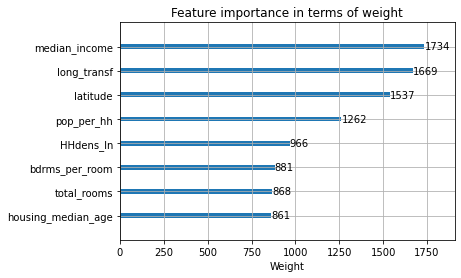

In [96]:
xgb.plot_importance(bst, importance_type= 'weight', xlabel= 'Weight',
                    ylabel= None, title="Feature importance in terms of weight");


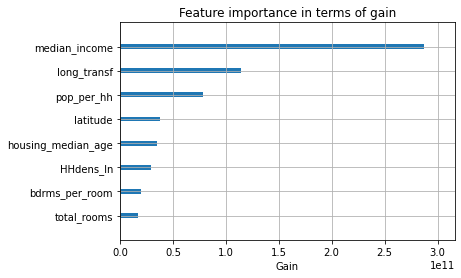

In [97]:
xgb.plot_importance(bst, importance_type= 'gain', xlabel="Gain", 
                    show_values= False, ylabel= None,
                    title="Feature importance in terms of gain");


In [84]:
# Function to obtain comparative rmse scores for our xgb model.

def get_xgb_rmse(seedv, dat):
    
    # dat needs to also have median_house_value as a column.
    n_rcds = 1000
    seedv_len = len(seedv)
    vout = np.zeros(seedv_len)
    
    for i, seed in enumerate(seedv):
        
        df = dat.sample(n=n_rcds, replace=False, random_state=seed, axis=0)
        y_df = df["median_house_value"].copy()
        df.drop(["median_house_value"], inplace=True, axis=1)
        
        df_test = xgb.DMatrix(df, label= y_df)
        df_preds = bst.predict(df_test)
        vout[i] = round(np.power(sum(np.power(df_preds - np.array(y_df), 2))/len(y_df), 0.5))
    
    return round(np.mean(vout[i]))


In [85]:
# The following is a score for all test districts.

testdat = X_test_8preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_xgb_rmse(smp, testdat)

print("Comparative rmse score for the xgb model:  " + '$' +
      f'{rmse_score:,.0f}')

# $49,090

# The previous gradient boosting model has a score of 48.4K.  But 
# it makes use of the ocean_proximity predictor.


Comparative rmse score for the xgb model:  $49,090


In [86]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_xgb_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.02 minutes

print("")
print("Comparative rmse score for the xgb model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $45,432

# The previous gradient boosting model has a score of 46.3K.


Time difference of 0.02 minutes

Comparative rmse score for the xgb model when median house value < 500K:  $45,432


## Try xgboost with the ocean_proximity predictor

As we see in what follows, the xgboost algorithm gives us a better model when we do *not* include ocean_proximity.

In [98]:
X_train_9preds.columns


Index(['median_income', 'long_transf', 'latitude', 'pop_per_hh', 'HHdens_ln',
       'housing_median_age', 'total_rooms', 'bdrms_per_room',
       'ocean_proximity'],
      dtype='object')

In [101]:
# We need to pass an ndarray object to xgb.DMatrix.  So the
# categorical variable needs to be converted to dummy variables.

dumvars_train = pd.get_dummies(X_train_9preds['ocean_proximity'])
dumvars_train.head()


,INLAND,NEAR BAY,NEAR OCEAN,OCEAN
334,0,1,0,0
1662,1,0,0,0
8781,0,0,0,1
9392,0,1,0,0
10706,0,0,0,1


In [102]:
X_train_xgb = X_train_9preds.join(dumvars_train)
X_train_xgb.drop(['ocean_proximity'], axis=1, inplace=True)
X_train_xgb.shape


(16482, 12)

In [119]:
# Do the same for the test set.

dumvars_test = pd.get_dummies(X_test_9preds['ocean_proximity'])
X_test_xgb = X_test_9preds.join(dumvars_test)
X_test_xgb.drop(['ocean_proximity'], axis=1, inplace=True)
X_test_xgb.shape


(4121, 12)

In [104]:
dtrain = xgb.DMatrix(X_train_xgb, label= y_train)

dtest = xgb.DMatrix(X_test_xgb, label= y_test)


### Find optimal parameters

In [106]:
params = {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.20,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=80, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
70,38883.0,424.0,56769.0,1839.0
71,38725.0,417.0,56775.0,1854.0
72,38589.0,410.0,56768.0,1872.0
73,38474.0,411.0,56755.0,1864.0
74,38340.0,439.0,56754.0,1892.0


In [109]:
params = {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.18,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=60, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
55,35815.0,459.0,56673.0,2423.0
56,35619.0,445.0,56637.0,2422.0
57,35462.0,439.0,56631.0,2425.0
58,35277.0,485.0,56627.0,2431.0
59,35077.0,496.0,56603.0,2417.0


In [112]:
params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.cv(params, dtrain, num_boost_round=48, nfold=10,
             metrics= ['rmse'], early_stopping_rounds= 3)

bst.tail().round()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
43,33683.0,559.0,56431.0,2286.0
44,33404.0,549.0,56416.0,2248.0
45,33177.0,569.0,56398.0,2194.0
46,32921.0,534.0,56350.0,2170.0
47,32608.0,600.0,56315.0,2190.0


### Construct xgb model for predictions

In [113]:

params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.train(params, dtrain, num_boost_round=48)

preds = bst.predict(dtest)
bst_rmse = round(np.power(sum(np.power(preds - np.array(y_test), 2))/len(y_test), 0.5))
print(bst_rmse)
# 52,770

# The score was a bit lower (52,696) without ocean_proximity.


52770


In [121]:
# The following is a score for all test districts.

testdat = X_test_xgb.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_xgb_rmse(smp, testdat)

print("Comparative rmse score for the xgb model that includes ocean_proximity:  " + '$' +
      f'{rmse_score:,.0f}')

# $49,678

# This score is not as good as the model which does not have ocean_proximity.


Comparative rmse score for the xgb model that includes ocean_proximity:  $49,678


In [122]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_xgb_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.02 minutes

print("")
print("Comparative rmse score for the xgb model when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $46,181

# The previous gradient boosting model has a score of 45.4K.


Time difference of 0.02 minutes

Comparative rmse score for the xgb model when median house value < 500K:  $46,181


## Run better model with more rounds

In [123]:
dtrain = xgb.DMatrix(X_train_8preds, label= y_train)

dtest = xgb.DMatrix(X_test_8preds, label= y_test)


In [132]:
params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.15,
          'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.train(params, dtrain, num_boost_round=80)

preds = bst.predict(dtest)
bst_rmse = round(np.power(sum(np.power(preds - np.array(y_test), 2))/len(y_test), 0.5))
print(bst_rmse)
# 52,366

# This same model at 60 rounds had a score of 52,696


52366


In [133]:
# The following is a score for all test districts.

testdat = X_test_8preds.join(y_test)

seed_choices = np.arange(start=1000, stop=21000, dtype=int)
np.random.seed(4321)
smp = np.random.choice(seed_choices, size=500, replace=False)

rmse_score = get_xgb_rmse(smp, testdat)

print("Comparative rmse score for the xgb model with 80 rounds:  " + '$' +
      f'{rmse_score:,.0f}')

# $48,548

# The gradient boosting model that included ocean_proximity has a
# score of 48.4K.


Comparative rmse score for the xgb model with 80 rounds:  $48,548


In [134]:
# The following is a score for districts with a median_house_value < 500K.

testdat2 = testdat[testdat.median_house_value < 500000].copy()

start_time = datetime.now()
rmse_score = get_xgb_rmse(smp, testdat2)
stop_time = datetime.now()
delta = stop_time - start_time
timeval = round(delta.seconds/60, 2)
print("Time difference of " + str(timeval) + " minutes")
# Time difference of 0.02 minutes

print("")
print("Comparative rmse score for the xgb model with 80 rounds when median house value < 500K:  " + '$' +
      f'{rmse_score:,.0f}')

# $45,139

# The gradient boosting model that included ocean_proximity
# has a score of 46.3K.


Time difference of 0.02 minutes

Comparative rmse score for the xgb model with 80 rounds when median house value < 500K:  $45,139


## Final comments on gradient boosting

Two of the gradient boosting models have near equal performance.  One uses ocean_proximity; the other does not.  I prefer the model with fewer predictors.  Its rmse score is about \\$150 more than the gradient boosting model that includes ocean_proximity.  But if we predict only for districts with a median house value < 500K, then the xgb model out-performs its cousin by \\$1,200.  Also, the xgboost model is quite a bit faster.

There may be other xgboost models that are even better.  I only scratched the surface here.


**Gradient boosted regression best score:**  **48.5K**


## Final comments for Part02

From the models surveyed, we obtain the best set of predictions, on average, from an xgboost model.  Recall that the g03 model from Part01 has an rmse score of 75.5K.  By contrast, the xgboost model has a score of 48.5K.  That is almost a 36% reduction in the score.

The work involved in producing the g03 model made life significantly easier when surveying the above range of machine learning models, for it provided me with a core set of predictors to focus on.  In the end, I went from using 6 predictors to using 8 of the original 13.  Also, because g03 is a parametric model that can be tuned without relying on cross-validation, I could use it in the Gibbs sampler to impute values for the records with a censored median house value.  
